In [1]:
from astro.load import Loader
from astro.preprocess import (
    Preprocessor,
    TracePreprocessor,
    GroupedEventPreprocessor,
)
from astro.transforms.groups import GroupSplitter
from astro.constants import SESSIONS, SESSION_MAPPER
from astro.decoding_alltime.preprocess import ATDecodePreprocessor, latency_mask_factory

from trace_minder.align import GroupedAligner

from pathlib import Path

from dataclasses import dataclass, field
from copy import deepcopy
from typing import Optional, Dict, List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
from sklearn.preprocessing import (
    StandardScaler,
    RobustScaler,
    MinMaxScaler,
    PowerTransformer,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, TimeSeriesSplit

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, KernelPCA, SparsePCA, TruncatedSVD, NMF
from sklearn.cross_decomposition import CCA, PLSCanonical, PLSRegression
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding

from sklearn.model_selection import BaseCrossValidator
from sklearn.base import BaseEstimator

In [3]:
DATA_DIR = Path("/Users/ruairiosullivan/Desktop/astro_data-02/dataset-02")
OUTPUT_DIR = Path("/Users/ruairiosullivan/Desktop/astro_data-02/Output-02")

### Loading and Preprocessing

In [4]:
loader = Loader(data_dir=DATA_DIR)

trace_preprocessor = TracePreprocessor(
    max_time=600,
    standardize=True,
    medfilt_kernel_size=None,
    resample_frequency=0.1,
)

event_preprocessor = GroupedEventPreprocessor(
    df_events_group_col="mouse_name",
    df_events_event_time_col="start_time",
    first_x_events=5,
)

loader_preprocessor = Preprocessor(
    trace_preprocessor=trace_preprocessor,
    grouped_event_preprocessor=event_preprocessor,
)

loader.set_preprocessor(loader_preprocessor)

In [5]:
# groups
group_info = GroupSplitter(
    df_mice=loader.load_mice(),
    df_neurons=loader.load_neurons(),
    df_traces_time_col="time",
    excluded_groups=["VEH-VEH"],
    df_neurons_mouse_col="mouse_name",
    df_mice_mouse_col="mouse_name",
    df_neurons_neuron_col="cell_id",
    df_mice_group_col="group",
)

In [6]:
# aligner
def aligner_fac() -> GroupedAligner:
    aligner = GroupedAligner(
        t_before=30,
        t_after=30,
        df_wide_group_mapper=group_info.neurons_by_mouse(),
        df_events_event_time_col="start_time",
        df_events_group_col="mouse_name",
    )
    return aligner

In [7]:
# run preprocessor
from astro.decoding_alltime.preprocess import all_time_decode_pp_fac
from astro.decoding_alltime.config import RunConfig, RunResults

### Configure Runs

In [10]:
def clf_fac():
    scaler = StandardScaler()
    clf = LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
    )
    clf_pipe = Pipeline([("scaler", scaler), ("clf", clf)])
    return clf_pipe


def cv_fac():
    cv = TimeSeriesSplit(n_splits=5)
    return cv


runs = (
    RunConfig(
        name="ret_full_VEH-CNO",
        group="VEH-CNO",
        preprocessor=all_time_decode_pp_fac(window_1=(-5, 0), window_2=(0, 5)),
        cv=cv_fac(),
        clf_pipe=clf_fac(),
    ),
    RunConfig(
        name="ret_full_CNO-VEH",
        group="CNO-VEH",
        preprocessor=all_time_decode_pp_fac(window_1=(-5, 0), window_2=(0, 5)),
        cv=cv_fac(),
        clf_pipe=clf_fac(),
    ),
)

In [42]:
from typing import Union, Callable


def fit_model(
    df_traces: pd.DataFrame,
    df_events: pd.DataFrame,
    preprocessor: Preprocessor,
    clf: BaseEstimator,
    cv: BaseCrossValidator,
    run_config: RunConfig,
    metric: Union[str, Callable],
) -> float:
    temporal_df, df, block_ts = preprocessor(
        df_traces=df_traces,
        block_starts=df_events,
    )
    X = df.values
    y = LabelEncoder().fit_transform(block_ts)

    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.train(X_train, y_train)
        y_pred = clf.predict(X_test)
        f1 = f1_score(y_test, y_pred)

    clf_score = cross_val_score(clf, X, y, cv=cv, scoring=metric, n_jobs=-1).mean()
    return clf_score

In [43]:
SESSION_NAME = "ret"
run_results = []

df_traces = loader.load_traces(session_name=SESSION_NAME)
df_events = loader.load_blockstarts(session_name=SESSION_NAME, block_group="CS")
trace_dict = group_info.traces_by_group(df_traces=df_traces)

for run_config in runs:
    df_traces_group = trace_dict[run_config.group]
    f1 = fit_model(
        df_traces=df_traces_group,
        df_events=df_events,
        preprocessor=run_config.preprocessor,
        clf=run_config.clf_pipe,
        cv=run_config.cv,
        run_config=run_config,
    )
    run_result = RunResults(
        name=run_config.name,
        group=run_config.group,
        clf=run_config.clf_pipe,
        config_str=str(run_config),
        f1=f1,
    )
    run_results.append(run_result)

In [44]:
# def result_to_df(results: List[RunResults]) -> pd.DataFrame:
#     df = pd.DataFrame(results)
#     df["f1"] = df["f1"].apply(lambda x: x.mean())
#     return df


df_res_full = pd.DataFrame(run_results).drop("clf", axis=1)
df_res_full

,name,group,config_str,f1
0,ret_full_VEH-CNO,VEH-CNO,"RunConfig(name='ret_full_VEH-CNO', group='VEH-...",0.917322
1,ret_full_CNO-VEH,CNO-VEH,"RunConfig(name='ret_full_CNO-VEH', group='CNO-...",0.789589


## PCs Runs

In [45]:
@dataclass
class RunConfigPCs:
    name: str
    group: str
    preprocessor: Preprocessor
    cv: BaseCrossValidator
    clf_pipe: BaseEstimator
    n_components: int


@dataclass
class RunResultsPCs:
    name: str
    group: str
    clf: BaseEstimator
    f1: float
    n_components: int
    config_str: str

In [46]:
def clf_pc_fac(num_pcs):
    scaler = StandardScaler()
    pca = PCA(n_components=num_pcs)
    clf = LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l2",
        solver="lbfgs",
        max_iter=1000,
    )
    clf_pipe = Pipeline([("scaler", scaler), ("pca", pca), ("clf", clf)])
    return clf_pipe

In [47]:
# make run configs


def make_run_config(group, num_pcs):
    return RunConfigPCs(
        name=f"ret_{group}_{num_pcs}-PCs",
        group=group,
        preprocessor=all_time_decode_pp_fac(window_1=(-5, 0), window_2=(0, 5)),
        cv=cv_fac(),
        clf_pipe=clf_pc_fac(num_pcs),
        n_components=num_pcs,
    )


runs = []
for group in group_info.groups:
    for num_pcs in range(1, 31):
        runs.append(make_run_config(group, num_pcs))

In [48]:
# run models

run_results_pcs = []

df_traces = loader.load_traces(session_name=SESSION_NAME)
df_events = loader.load_blockstarts(session_name=SESSION_NAME, block_group="CS")

for run in tqdm(runs):
    df_traces_group = trace_dict[run.group]
    f1 = fit_model(
        df_traces=df_traces_group,
        df_events=df_events,
        preprocessor=run.preprocessor,
        clf=run.clf_pipe,
        cv=run.cv,
        run_config=run,
    )
    run_result = RunResultsPCs(
        name=run.name,
        group=run.group,
        clf=run.clf_pipe,
        config_str=str(run),
        f1=f1,
        n_components=run.n_components,
    )
    run_results_pcs.append(run_result)

 23%|██▎       | 14/60 [00:13<00:46,  1.01s/it]/opt/miniconda3/envs/astro/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 25%|██▌       | 15/60 [00:14<00:46,  1.03s/it]/opt/miniconda3/envs/astro/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for

/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='n_components', ylabel='f1'>

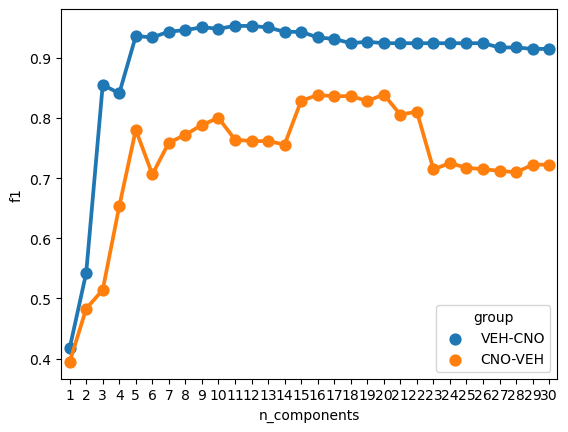

In [49]:
df_res_pcs = pd.DataFrame(run_results_pcs)

sns.pointplot(
    data=df_res_pcs, x="n_components", y="f1", hue="group", estimator=np.median
)

### Limit Neurons Runs

In [50]:
@dataclass
class RunConfigNeurons:
    name: str
    group: str
    preprocessor: Preprocessor
    cv: BaseCrossValidator
    clf_pipe: BaseEstimator
    n_neurons: int


@dataclass
class RunResultsNeurons:
    name: str
    group: str
    clf: BaseEstimator
    f1: float
    n_neurons: int
    config_str: str

In [61]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


def clf_neurons_fac_logreg(k_neurons):
    scaler = StandardScaler()
    selecter = SelectKBest(k=k_neurons, score_func=f_classif)
    clf = LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="liblinear",
        max_iter=1000,
    )

    clf_pipe = Pipeline([("scaler", scaler), ("selecter", selecter), ("clf", clf)])
    return clf_pipe


def make_run_config_neurons_forrest(group, k_neurons):
    return RunConfigNeurons(
        name=f"ret_{group}_{k_neurons}-neurons",
        group=group,
        preprocessor=all_time_decode_pp_fac(window_1=(-5, 0), window_2=(0, 5)),
        cv=cv_fac(),
        clf_pipe=clf_neurons_fac_logreg(k_neurons),
        n_neurons=k_neurons,
    )


runs_logreg = []
for group in group_info.groups:
    for k_neurons in range(1, 31):
        runs_logreg.append(make_run_config_neurons_forrest(group, k_neurons))


# run models
run_results_neurons_logreg = []

df_traces = loader.load_traces(session_name=SESSION_NAME)
df_events = loader.load_blockstarts(session_name=SESSION_NAME, block_group="CS")


for run in tqdm(runs_logreg):
    df_traces_group = trace_dict[run.group]
    f1 = fit_model(
        df_traces=df_traces_group,
        df_events=df_events,
        preprocessor=run.preprocessor,
        clf=run.clf_pipe,
        cv=run.cv,
        run_config=run,
    )
    run_result = RunResultsNeurons(
        name=run.name,
        group=run.group,
        clf=run.clf_pipe,
        config_str=str(run),
        f1=f1,
        n_neurons=run.n_neurons,
    )
    run_results_neurons_logreg.append(run_result)

df_res_neurons_logreg = pd.DataFrame(run_results_neurons_logreg)

100%|██████████| 60/60 [00:57<00:00,  1.05it/s]


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='n_neurons', ylabel='f1'>

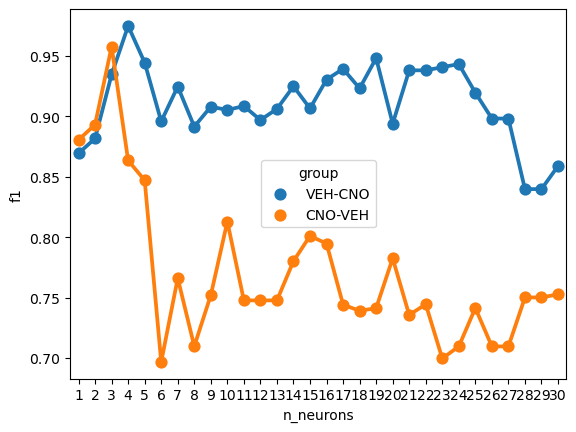

In [62]:
sns.pointplot(
    data=df_res_neurons_logreg, x="n_neurons", y="f1", hue="group", estimator=np.median
)

In [57]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier


def clf_neurons_fac_forrest(k_neurons):
    scaler = StandardScaler()
    selecter = SelectKBest(k=k_neurons, score_func=f_classif)
    clf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    clf_pipe = Pipeline([("scaler", scaler), ("selecter", selecter), ("clf", clf)])
    return clf_pipe


def make_run_config_neurons_forrest(group, k_neurons):
    return RunConfigNeurons(
        name=f"ret_pcs_{group}",
        group=group,
        preprocessor=all_time_decode_pp_fac(window_1=(-5, 0), window_2=(0, 5)),
        cv=cv_fac(),
        clf_pipe=clf_neurons_fac_forrest(k_neurons),
        n_neurons=k_neurons,
    )


runs_forrest = []
for group in group_info.groups:
    for k_neurons in range(1, 31):
        runs_forrest.append(make_run_config_neurons_forrest(group, k_neurons))


# run models
run_results_neurons_forrest = []

df_traces = loader.load_traces(session_name=SESSION_NAME)
df_events = loader.load_blockstarts(session_name=SESSION_NAME, block_group="CS")


for run in tqdm(runs_forrest):
    df_traces_group = trace_dict[run.group]
    f1 = fit_model(
        df_traces=df_traces_group,
        df_events=df_events,
        preprocessor=run.preprocessor,
        clf=run.clf_pipe,
        cv=run.cv,
        run_config=run,
    )
    run_result = RunResultsNeurons(
        name=run.name,
        group=run.group,
        clf=run.clf_pipe,
        config_str=str(run),
        f1=f1,
        n_neurons=run.n_neurons,
    )
    run_results_neurons_forrest.append(run_result)

df_res_neurons_forrest = pd.DataFrame(run_results_neurons_forrest)

100%|██████████| 60/60 [01:01<00:00,  1.02s/it]


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

(0.5, 1.0)

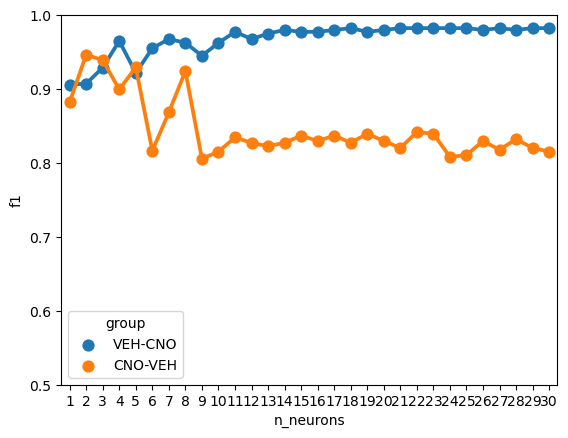

In [63]:
ax = sns.pointplot(
    data=df_res_neurons_forrest, x="n_neurons", y="f1", hue="group", estimator=np.median
)


ax.set_ylim(0.5, 1)

In [59]:
with pd.ExcelWriter(OUTPUT_DIR / "ret_alltime_decoding_5sec-around-CS.xlsx") as writer:
    df_res_full.to_excel(writer, sheet_name="full")
    df_res_pcs.drop("config_str", axis=1).to_excel(writer, sheet_name="pcs")
    df_res_neurons_logreg.drop("config_str", axis=1).to_excel(
        writer, sheet_name="neurons_logreg"
    )
    df_res_neurons_forrest.drop("config_str", axis=1).to_excel(
        writer, sheet_name="neurons_forrest"
    )

In [35]:
# make run configs


# with pd.ExcelWriter(OUTPUT_DIR / "ret_alltime_decoding.xlsx") as writer:
#     df_res_full.to_excel(writer, sheet_name="full")
#     df_res_pcs.drop("config_str", axis=1).to_excel(writer, sheet_name="pcs")
#     df_res_neurons_logreg.drop("config_str", axis=1).to_excel(writer, sheet_name="neurons_logreg")
#     df_res_neurons_forrest.drop("config_str", axis=1).to_excel(writer, sheet_name="neurons_forrest")

In [ ]:
# run models

run_results_neurons_forrest = []

df_traces = loader.load_traces(session_name=SESSION_NAME)
df_events = loader.load_blockstarts(session_name=SESSION_NAME, block_group="CS")


for run in tqdm(runs):
    df_traces_group = trace_dict[run.group]
    f1 = fit_model(
        df_traces=df_traces_group,
        df_events=df_events,
        preprocessor=run.preprocessor,
        clf=run.clf_pipe,
        cv=run.cv,
        run_config=run,
    )
    run_result = RunResultsNeurons(
        name=run.name,
        group=run.group,
        clf=run.clf_pipe,
        config_str=str(run),
        f1=f1,
        n_neurons=run.n_neurons,
    )
    run_results_neurons_forrest.append(run_result)

df_res_neurons_forrest = pd.DataFrame(run_results_neurons_forrest)

100%|██████████| 60/60 [00:59<00:00,  1.02it/s]


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='n_neurons', ylabel='f1'>

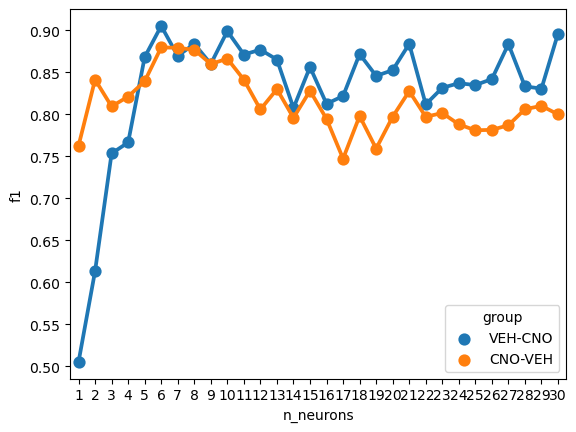

In [128]:
df_res_neurons = pd.DataFrame(run_results_neurons)

sns.pointplot(
    data=df_res_neurons, x="n_neurons", y="f1", hue="group", estimator=np.median
)

In [129]:
df_res_neurons.to_csv(OUTPUT_DIR / "ret_neurons.csv")

,name,group,clf,f1,n_neurons,config_str
0,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=1), RandomFor...",0.505444,1,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
1,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=2), RandomFor...",0.613517,2,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
2,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=3), RandomFor...",0.753465,3,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
3,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=4), RandomFor...",0.766492,4,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
4,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=5), RandomFor...",0.868020,5,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
5,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=6), RandomFor...",0.905131,6,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
6,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=7), RandomFor...",0.869373,7,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
7,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=8), RandomFor...",0.883804,8,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
8,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(k=9), RandomFor...",0.859911,9,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
9,ret_pcs_VEH-CNO,VEH-CNO,"(StandardScaler(), SelectKBest(), RandomForest...",0.898906,10,"RunConfigNeurons(name='ret_pcs_VEH-CNO', group..."
